# 📊 Marketing Campaign Analysis and A/B Testing 

---

**Objective:** Analyze the effectiveness of 3 different marketing campaigns (A, B, C) across multiple stores and customer segments over 4 weeks.

**Key Questions:**
- Are the groups balanced in terms of location, store size, and historical performance?
- Which campaign has the highest conversion rate and revenue per customer?
- Are differences statistically significant?

## Table of contents

- 1. Simulation Context & Data Description
- 2. Data Preparation
- 3. Group Balance Check
- 4. KPI Creation
- 5. Exploratory Data Analysis (EDA)
- 6. Statistical Testing (ANOVA, Z-test, Post-hoc)
- 7. Segmented Analysis (store, customer, gender...)
- 8. Final Insights & Recommendations


## 1. Simulation Context & Data Description

### 1.1. Simulation Context

This dataset simulates a real-world A/B/C test scenario for a retail clothing chain that is launching a **New Collection**.

#### 1.1. Objective
Evaluate the effectiveness of three different **marketing campaigns** across store locations, based on customer behavior and revenue performance.

#### 1.2. Store Setup
- **150 stores** randomly assigned to one of three campaigns (**A**, **B**, **C**)
- Stratified by:
  - `store_location`: Urban / Suburban / Rural
  - `store_size_category`: Small / Medium / Large
- Store-level attributes include:
  - `avg_revenue_last_3_months`
  - `monthly_active_customers`

#### 1.3. Customer Simulation
- Approx. **30,000 customers** interacted across **4 weeks**
- Each customer is assigned to only one store
- Only customers with **at least one purchase** are included
- Weekly records include:
  - `visit_count`, `products_ord`, `new_collection_items`, `revenue`
  - Demographics: `age`, `gender`
  - Promotion usage and gift received if eligible

#### 1.4. Campaign Summary

- **Campaign A**: In the assigned store, if a customer purchases at least one new collection item, they receive a 5% discount on the entire order.

- **Campaign B**: In the assigned store, if a customer purchases at least one new collection item, they receive a random free gift (e.g., Tote Bag, Socks, Keychain, or Stickers).

- **Campaign C**: Through an email/SMS announcement, if a customer purchases at least one new collection item at the store specified in the message, they have a 50% chance to receive a 10% discount via a loyalty voucher.

This dataset is designed to support analysis such as A/B testing, segmentation, behavioral trends, and campaign performance evaluation.


### 1.2. Dataset Description

This dataset simulates a 4-week A/B/C marketing experiment run by a retail clothing chain to evaluate the effectiveness of three different promotional strategies for a new product collection. Only customers who made at least one purchase are included.

Each customer is assigned to one store (with a fixed campaign) and the dataset includes rich demographic, store-level, and transactional information.

#### 🧷 Columns Overview

| Column Name                 | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| `customer_id`               | Unique ID for each customer                                                 |
| `week`                      | Week number of the transaction (1 to 4)                                     |
| `store_id`                  | Unique ID of the store visited                                              |
| `campaign_group`            | Type of marketing campaign assigned to the store: A, B, or C                |
| `store_location`            | Store’s geographical location (`Urban`, `Suburban`, `Rural`)                |
| `store_size_category`       | Store size classification (`Small`, `Medium`, `Large`)                      |
| `avg_revenue_last_3_months` | Average revenue of the store prior to the campaign                          |
| `monthly_active_customers`  | Average number of monthly active customers at the store                     |
| `customer_segment`          | Type of customer (`New`, `Returning`)                                       |
| `age`                       | Age of the customer (only for purchasing customers)                         |
| `gender`                    | Gender of the customer (`Male`, `Female`)                                   |
| `visit_count`               | Number of visits resulting in a purchase during the week                    |
| `products_ord`              | Total number of products purchased                                          |
| `new_collection_items`      | Number of items from the new collection purchased                           |
| `other_products_ord`        | Number of products outside the new collection                               |
| `discount`                  | Discount rate applied (0%, 5%, or 10%)                                      |
| `gift_received`             | Gift received (if campaign B & eligible), else blank                        |
| `used_loyalty_or_voucher`   | Whether loyalty points/voucher was applied (for campaign C)                 |
| `promo_used`                | Whether any promo was used (gift or discount)                               |
| `revenue_before_discount`   | Original order value before applying discount                               |
| `revenue`                   | Final order revenue after discount                                          |


## 2. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('ab_marketing_campaign_stratified.csv')
df.head()

,customer_id,week,store_id,campaign_group,store_location,store_size_category,avg_revenue_last_3_months,monthly_active_customers,customer_segment,age,...,products_ord,new_collection_items,other_products_ord,discount,gift_received,used_loyalty_or_voucher,promo_used,revenue_before_discount,revenue,used_new_collection
0,2,1,S141,A,Rural,Small,156279.0,2761,Returning,18.0,...,3,0,3,0.00,NaN,False,No,257.339184,257.34,False
1,3,1,S118,A,Urban,Medium,114664.0,2219,Returning,22.0,...,5,1,4,0.05,NaN,False,Yes,456.174741,433.37,True
2,4,1,S057,A,Urban,Small,127025.0,1380,Returning,18.0,...,3,1,2,0.05,NaN,False,Yes,240.945008,228.90,True
3,6,1,S105,A,Rural,Small,99363.0,2600,New,19.0,...,5,1,4,0.05,NaN,False,Yes,314.321130,298.61,True
4,8,1,S107,C,Suburban,Large,130323.0,704,Returning,18.0,...,5,0,5,0.00,NaN,False,No,84.453205,84.45,False


## 3. Group Balance Check

### Why Perform Group Balance Check?

Before comparing outcomes across different groups in an A/B/C test, it's essential to verify that the groups are balanced in terms of key characteristics. Otherwise, observed differences might be due to pre-existing differences — not the effect of the campaign.

#### Reasons to Perform Balance Check

1. **Ensure Fair Comparison**
   - If groups differ in demographics, location, or store size, any observed revenue differences might be biased.

2. **Support Valid Statistical Testing**
   - Most statistical tests assume that groups are similar in underlying characteristics.
   - Unbalanced groups can lead to misleading p-values (false positives or negatives).

3. **Detect Hidden Bias**
   - Example: Group B has mostly returning customers, Group C has mostly new customers → result is influenced by customer loyalty, not the campaign.

---

#### Steps

1. **Visual Checks**
   - Bar charts / Boxplots for variables like:
     - `store_location`, `store_size_category`
     - `age`, `gender`, `customer_segment`
     - `avg_revenue_last_3_months`, `monthly_active_customers`

2. **Statistical Tests**
   - **Chi-squared test** for categorical variables
   - **ANOVA / Kruskal-Wallis test** for numerical variables

3. **Document Any Imbalance**
   - If significant imbalance exists, consider:
     - Controlling for those variables in later analysis (e.g., regression)
     - Stratifying results or filtering

---

> A balance check helps ensure that any differences in campaign outcomes are **due to the campaign itself**, not underlying group biases.

### 3.1. Store balance checks

#### Store Location Distribution by Campaign

In [3]:
pd.crosstab(df['campaign_group'], df['store_location'])

store_location,Rural,Suburban,Urban
campaign_group,,,
A,6784,9787,13435
B,4026,6350,9160
C,2238,3811,5367


- The Rural/Suburban/Urban ratio between groups is not too different. 
- Small differences (less than 10%) between groups are acceptable in the context of real-life simulation data.

#### Store Size Category Distribution by Campaign

In [4]:
pd.crosstab(df['campaign_group'], df['store_size_category'])

store_size_category,Large,Medium,Small
campaign_group,,,
A,6481,14549,8976
B,4417,9575,5544
C,2100,5772,3544


- Medium stores account for about 50% of all three groups. 
- The difference between the groups is very small, so it does not affect the A/B test results.

#### Baseline Revenue Distribution

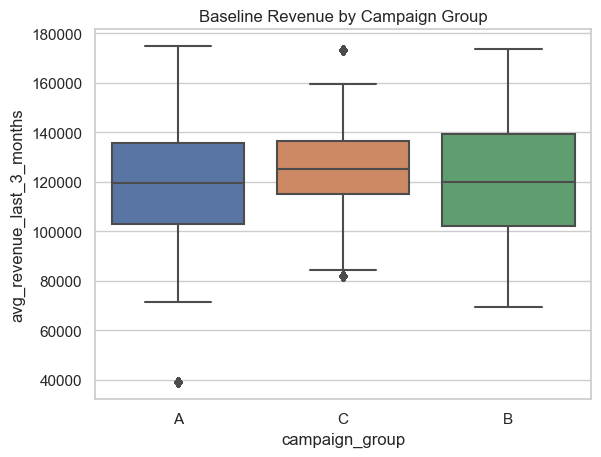

In [5]:
# Distribution of baseline revenue and customer demographics
sns.boxplot(x='campaign_group', y='avg_revenue_last_3_months', data=df)
plt.title('Baseline Revenue by Campaign Group')
plt.show()

- The distribution of average revenue over the past 3 months among groups A, B, and C is quite even.

- There are no significant differences in medians, quartiles, or outliers among groups.

> ✅ Conclusion: Data has been allocated reasonably between A/B/C groups → Ensure group balance requirements for A/B tests, reducing the risk of bias from store-side noise variables.

### 3.2. Demographic checks + Chi-Square

> Gender Distribution per Campaign

In [6]:
# Count distribution
gender_ct = pd.crosstab(df['campaign_group'], df['gender'])
display(gender_ct)

# Chi-square test
from scipy.stats import chi2_contingency
chi2_gender = chi2_contingency(gender_ct)
print(f"Chi-square p-value (Gender vs Campaign): {chi2_gender[1]:.4f}")

gender,Female,Male
campaign_group,,
A,15048,14958
B,9721,9815
C,5695,5721


Chi-square p-value (Gender vs Campaign): 0.6816


- Chi-square p-value = 0.6816 → there is no significant difference in gender distribution between campaign groups.

- Conclusion: The gender ratio between the 3 groups A-B-C is balanced, no adjustment is needed.

>  Age Distribution (Visual + ANOVA)

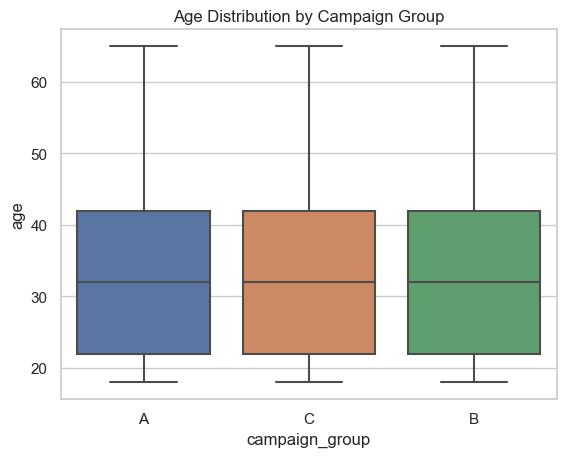

ANOVA p-value (Age vs Campaign): 0.1083


In [7]:
# Boxplot
sns.boxplot(x='campaign_group', y='age', data=df)
plt.title("Age Distribution by Campaign Group")
plt.show()

# ANOVA test
from scipy.stats import f_oneway
group_A = df[df['campaign_group'] == 'A']['age']
group_B = df[df['campaign_group'] == 'B']['age']
group_C = df[df['campaign_group'] == 'C']['age']
anova_age = f_oneway(group_A, group_B, group_C)
print(f"ANOVA p-value (Age vs Campaign): {anova_age.pvalue:.4f}")

- Boxplot shows that the age distribution of the 3 groups is quite similar, no group has a clear difference.

- ANOVA p-value = 0.1083 (> 0.05) → there is no statistically significant difference in age between groups.

> ✅ Conclusion: This is an extremely important step to ensure that the A/B test results are reliable and not biased by background factors.

## 4. KPI Creation

> Why need KPI Creation?

- Creating quantitative metrics to evaluate and compare the effectiveness of each campaign group according to specific criteria.

> 3 KPI criteria include:

* Engagement & Conversion

* Revenue & Promotion

* Promotion Effectiveness

### 4.1. Calculate KPI by campaign_group

In [8]:
df.describe()

,customer_id,week,avg_revenue_last_3_months,monthly_active_customers,age,visit_count,products_ord,new_collection_items,other_products_ord,discount,revenue_before_discount,revenue
count,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000
mean,15045.650120,2.497933,121015.122232,1706.374373,33.390318,1.501509,3.004478,0.617917,2.386561,0.016940,195.776262,191.388667
std,8655.174953,1.116823,23966.103729,757.559264,12.592078,0.500002,1.415244,0.803820,1.351439,0.025536,125.431384,121.071934
min,2.000000,1.000000,38968.000000,509.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,9.000000
25%,7542.250000,1.000000,103667.000000,1017.000000,22.000000,1.000000,2.000000,0.000000,1.000000,0.000000,89.810092,88.792500
50%,15074.000000,2.000000,120315.000000,1644.000000,32.000000,2.000000,3.000000,0.000000,2.000000,0.000000,173.619879,170.570000
75%,22547.000000,3.000000,136553.000000,2468.000000,42.000000,2.000000,4.000000,1.000000,3.000000,0.050000,279.162640,272.790000
max,30000.000000,4.000000,174745.000000,2997.000000,65.000000,2.000000,5.000000,5.000000,5.000000,0.100000,600.000000,600.000000


In [9]:
# Calculate KPI by campaign_group
kpi_df = df.groupby('campaign_group').agg(
    total_customers=('customer_id', 'nunique'),
    total_visits=('visit_count', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    total_revenue=('revenue', 'sum'),
    new_customers=('customer_segment', lambda x: (x == 'New').sum()),
    promo_used=('promo_used', lambda x: (x == 'Yes').sum()),
    revenue_by_promo=('revenue', lambda x: x[df.loc[x.index, 'promo_used'] == 'Yes'].sum())
).reset_index()

# Thêm returning_customers: = total_customers - new_customers
kpi_df['returning_customers'] = kpi_df['total_customers'] - kpi_df['new_customers']

In [10]:
kpi_df.head()

,campaign_group,total_customers,total_visits,total_products,total_new_collection,total_revenue,new_customers,promo_used,revenue_by_promo,returning_customers
0,A,10630,44996,90229,27086,6938192.11,2848,18408,4798827.28,7782
1,B,9187,29415,58506,8147,3507288.04,1244,6788,1451393.16,7943
2,C,7203,17118,34412,2434,1221190.20,421,1122,134011.14,6782


### 4.2. KPIs for Engagement and Conversion criteria

In [11]:
kpi_df['products_ord_per_visit_count'] = kpi_df['total_products'] / kpi_df['total_visits']
kpi_df['products_ord_per_customer'] = kpi_df['total_products'] / kpi_df['total_customers']
kpi_df['share_of_new_collection'] = kpi_df['total_new_collection'] / kpi_df['total_products']
kpi_df['new_collection_items_per_customer'] = kpi_df['total_new_collection'] / kpi_df['total_customers']
kpi_df['new_collection_items_per_visit_count'] = kpi_df['total_new_collection'] / kpi_df['total_visits']
kpi_df['new_customer_rate'] = kpi_df['new_customers'] / kpi_df['total_customers']

### 4.3. KPIs for Revenue criteria

In [12]:
kpi_df['revenue_per_customer'] = kpi_df['total_revenue'] / kpi_df['total_customers']
kpi_df['revenue_per_visit_count'] = kpi_df['total_revenue'] / kpi_df['total_visits']
kpi_df['revenue_per_product'] = kpi_df['total_revenue'] / kpi_df['total_products']
kpi_df['revenue_per_new_collection_item'] = kpi_df['total_revenue'] / kpi_df['total_new_collection']
kpi_df['revenue_per_new_customer'] = kpi_df['total_revenue'] / kpi_df['new_customers']
kpi_df['revenue_per_returning_customer'] = kpi_df['total_revenue'] / kpi_df['returning_customers']

### 4.4. KPIs for Promotion Effectiveness criteria

In [13]:
kpi_df['promo_utilization_rate'] = kpi_df['promo_used'] / kpi_df['total_customers']
kpi_df['avg_revenue_by_promo'] = kpi_df['revenue_by_promo'] / kpi_df['promo_used']

### 4.5. Display KPI DataFrame

In [14]:
kpi_df[['campaign_group', 'products_ord_per_visit_count', 'products_ord_per_customer', 'share_of_new_collection',
        'new_collection_items_per_customer', 'new_collection_items_per_visit_count', 'new_customer_rate',
        'total_revenue', 'revenue_per_customer', 'revenue_per_visit_count', 'revenue_per_product',
        'revenue_per_new_collection_item', 'revenue_per_new_customer', 'revenue_per_returning_customer',
        'promo_utilization_rate', 'avg_revenue_by_promo']]

,campaign_group,products_ord_per_visit_count,products_ord_per_customer,share_of_new_collection,new_collection_items_per_customer,new_collection_items_per_visit_count,new_customer_rate,total_revenue,revenue_per_customer,revenue_per_visit_count,revenue_per_product,revenue_per_new_collection_item,revenue_per_new_customer,revenue_per_returning_customer,promo_utilization_rate,avg_revenue_by_promo
0,A,2.005267,8.488147,0.300192,2.548071,0.601965,0.267921,6938192.11,652.699164,154.195753,76.895367,256.154180,2436.162960,891.569277,1.731703,260.692486
1,B,1.988985,6.368347,0.139251,0.886797,0.276968,0.135409,3507288.04,381.766413,119.234678,59.947493,430.500557,2819.363376,441.557099,0.738870,213.817496
2,C,2.010282,4.777454,0.070731,0.337915,0.142190,0.058448,1221190.20,169.539109,71.339537,35.487336,501.721528,2900.689311,180.063433,0.155768,119.439519


## 5. Exploratory Data Analysis (EDA) by KPI Group

> EDA implementation revolves around the KPIs just created to:

- Stick to A/B testing goals on campaign effectiveness

- Clearly explain customer/store behavior associated with performance

- Prepare directly for statistical testing and segment analysis

### 5.1. Engagement & Conversion

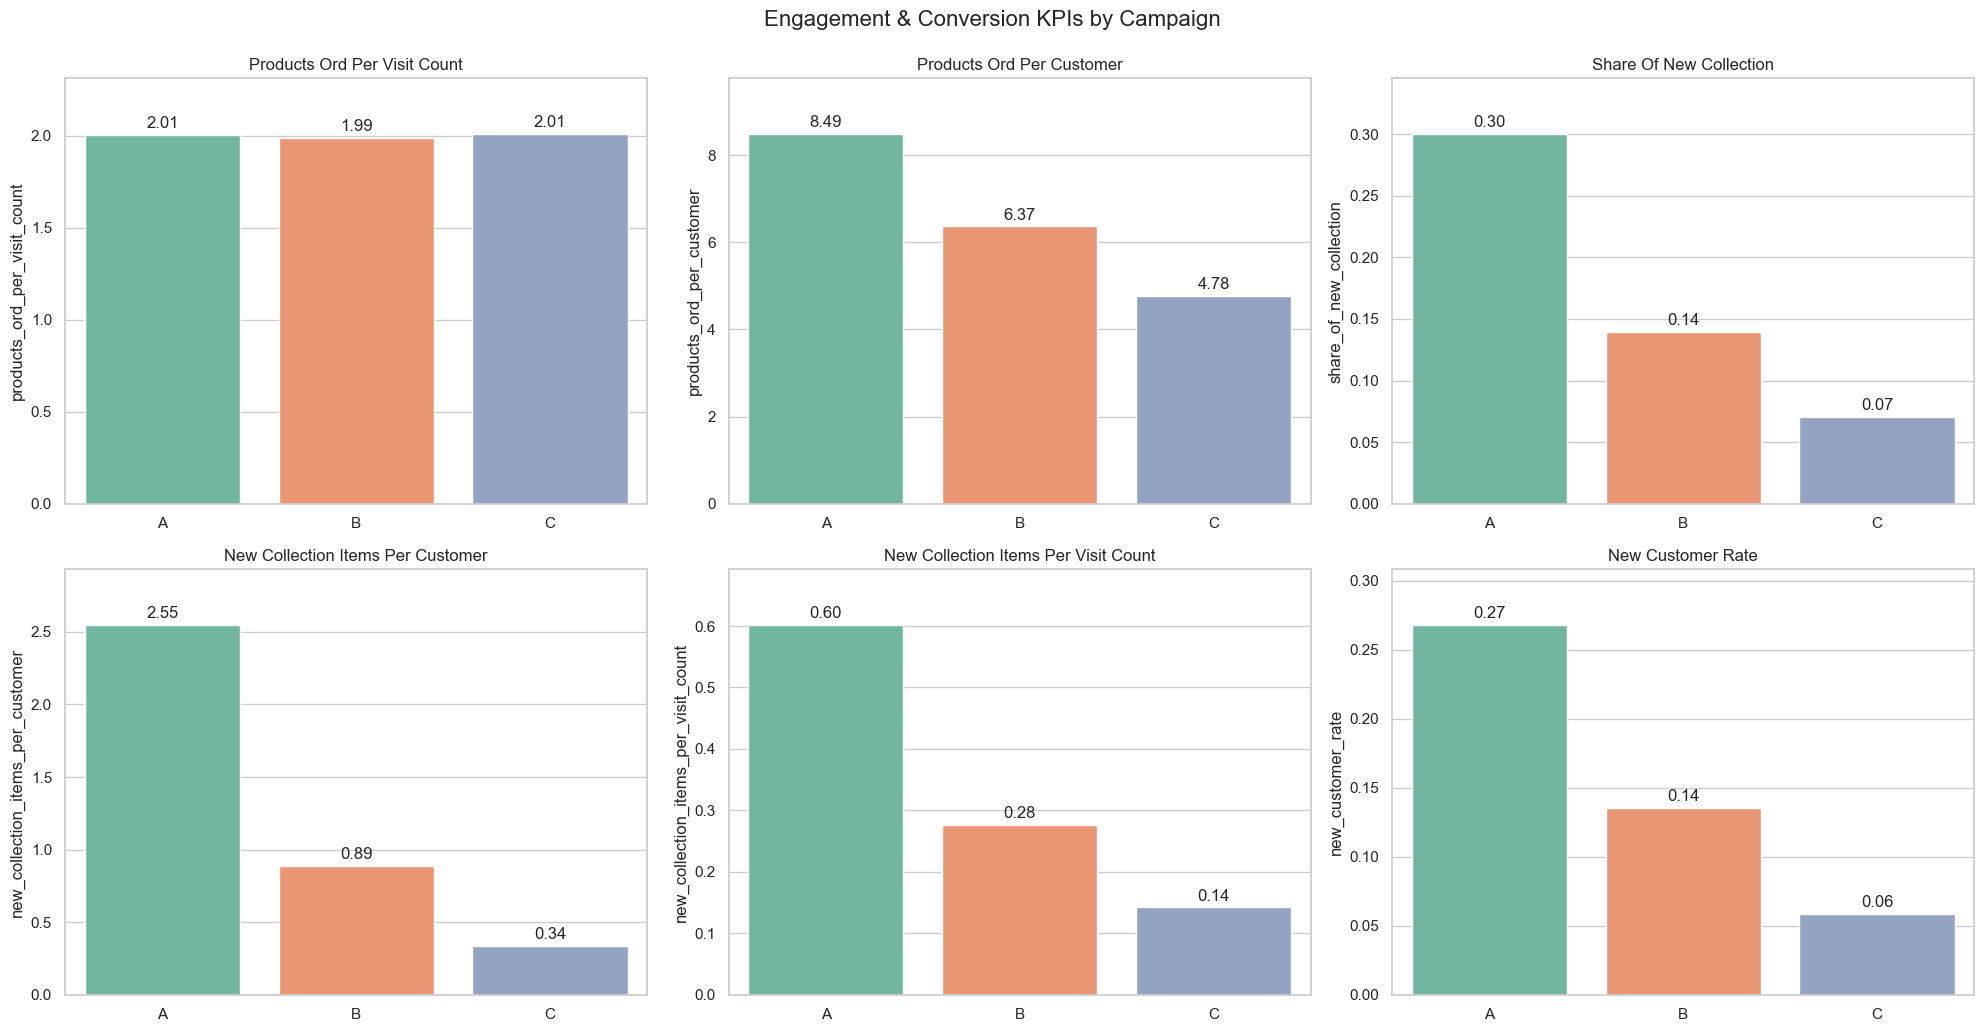

In [15]:
engagement_metrics = [
    'products_ord_per_visit_count', 'products_ord_per_customer', 'share_of_new_collection',
    'new_collection_items_per_customer', 'new_collection_items_per_visit_count', 'new_customer_rate'
]

plt.figure(figsize=(20, 10))

for i, metric in enumerate(engagement_metrics):
    plt.subplot(2, 3, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='Set2')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(), 
            f'{p.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Optional: create space between data label and bar
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Engagement & Conversion KPIs by Campaign", fontsize=16, y=1.03)
plt.show()

> Campaign A demonstrates the highest engagement and conversion performance across almost all KPIs, especially:

- New collection items per customer and per visit.

- Highest new customer rate and share of new collection items.

> Campaign C shows the lowest performance in all metrics, notably:

- Very low new customer rate (~6%) and minimal adoption of new collection products.

> Campaign B stands in the middle, delivering moderate effectiveness.

> ⚠️ Suggestion: **Campaign A seems most effective in driving new customer acquisition and new product engagement**, making it a key candidate for deeper analysis and benchmarking.

### 5.2. Revenue

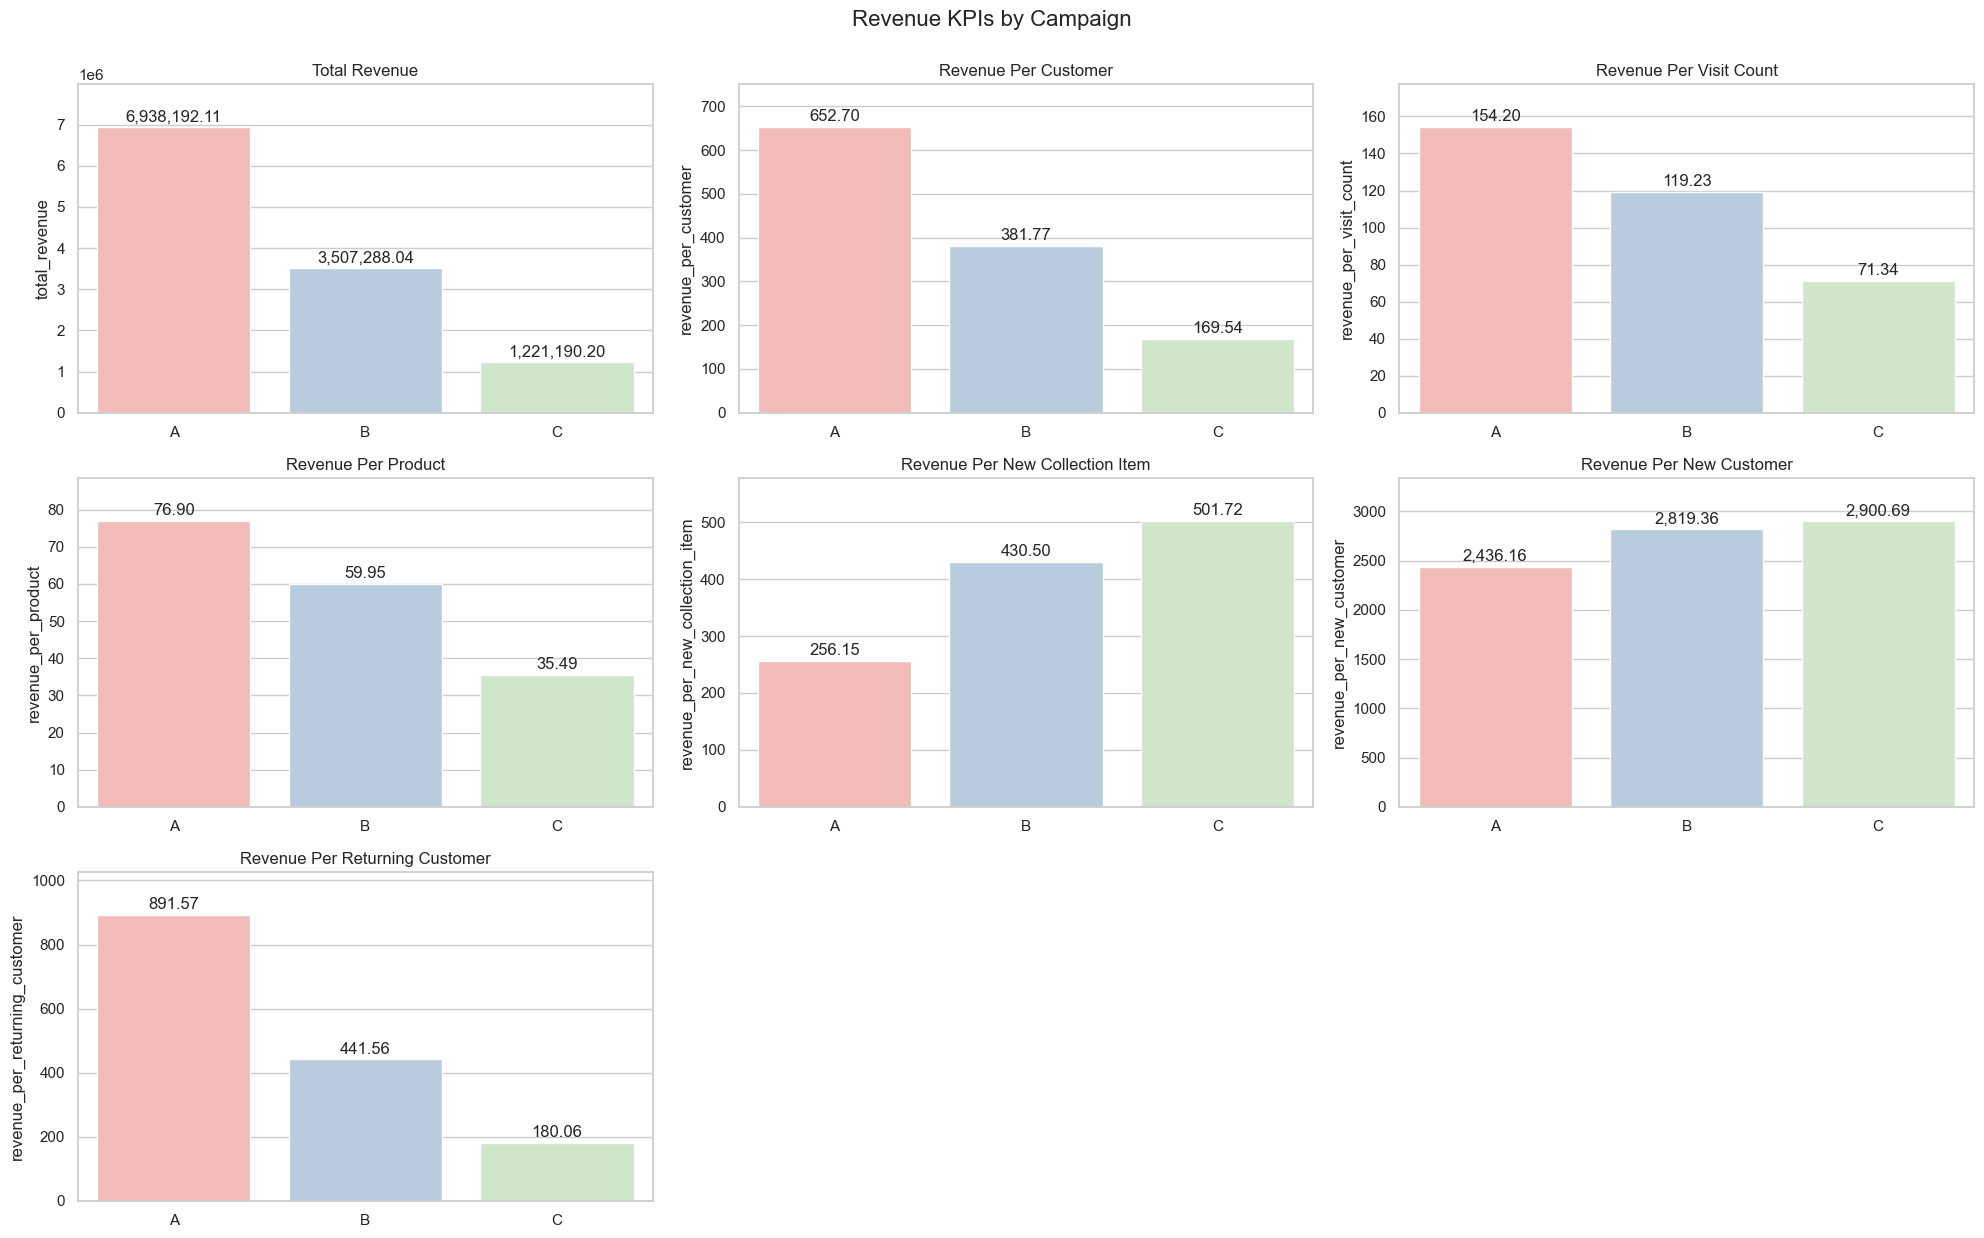

In [16]:
revenue_metrics = [
    'total_revenue', 'revenue_per_customer', 'revenue_per_visit_count',
    'revenue_per_product', 'revenue_per_new_collection_item',
    'revenue_per_new_customer', 'revenue_per_returning_customer'
]

plt.figure(figsize=(20, 12))

for i, metric in enumerate(revenue_metrics):
    plt.subplot(3, 3, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='Pastel1')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(),  # adjust spacing
            f'{p.get_height():,.2f}',  # format with comma and 2 decimals
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Optional: extend Y axis for better label visibility
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Revenue KPIs by Campaign", fontsize=16, y=1.03)
plt.show()

> Campaign A leads across most revenue KPIs, especially:

- Total Revenue

- Revenue per Customer and Returning Customer

- Revenue per Visit and per Product

> Campaign B ranks second overall, with strengths in:

- Revenue per Customer and Visit

- Strong efficiency with new collection items

> Campaign C shows the lowest performance overall, but stands out in:

- Highest revenue per new customer

- Highest revenue per new collection item

- This also makes sense because the rate of new customers and the rate of purchasing products in the new collection in Campaign C is the lowest among the 3 campaigns.

### 5.3. Promotion Effectiveness

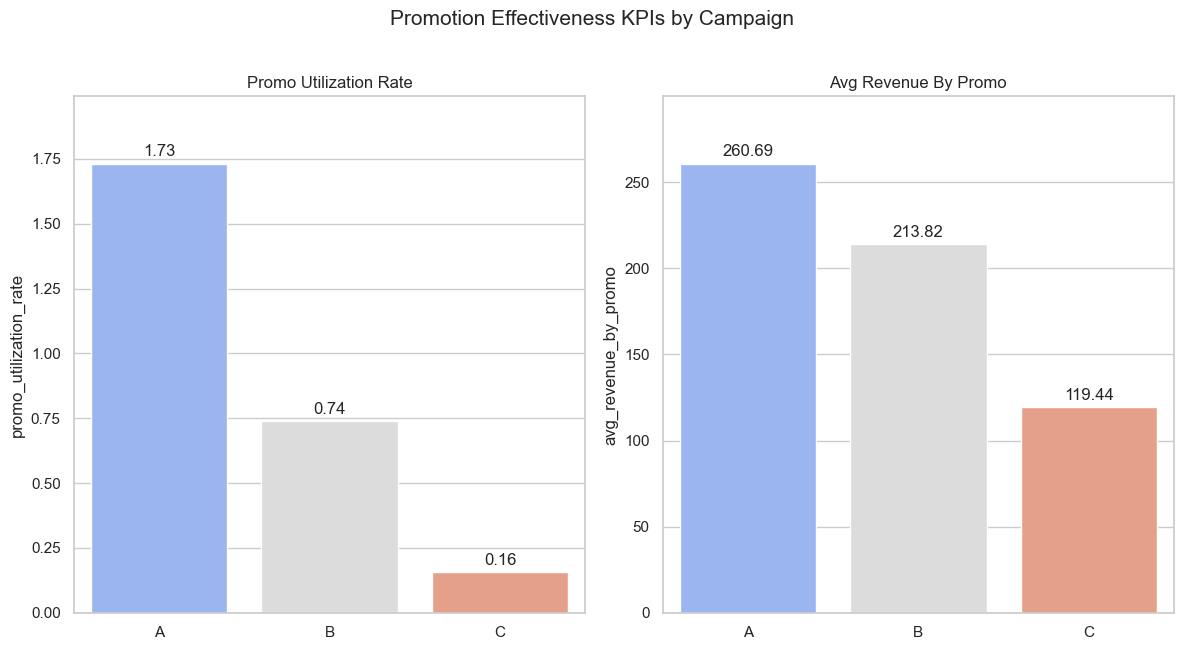

In [17]:
promotion_metrics = ['promo_utilization_rate', 'avg_revenue_by_promo']

plt.figure(figsize=(12, 6))
for i, metric in enumerate(promotion_metrics):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='coolwarm')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(),
            f'{p.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Adjust Y limit for label visibility
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Promotion Effectiveness KPIs by Campaign", fontsize=15, y=1.08)
plt.show()

> Campaign A stands out as the most effective:

- Promo utilization rate (1.73) is over 2x B and 10x C.

- Avg revenue per promo (260.69) is also the highest, indicating strong usage and good revenue conversion from promotions.

> Campaign B performs moderately:

- Utilization and promo revenue are decent, but not as high as A.

> Campaign C underperforms significantly:

- Lowest values in both utilization (0.16) and revenue per promo (119.44).

### 5.4. Overall Conclusion & Recommendation

#### Conclusion:

> Campaign A is the most effective and well-rounded campaign, leading in:

- New customer acquisition

- Engagement with new collection items

- Revenue performance across all key metrics

- Promotion effectiveness, with the highest usage and revenue from promotions

> Campaign B performs moderately and consistently:

- Delivers solid results in new product efficiency and revenue per customer/visit

- Can serve as a supporting or control strategy

> Campaign C shows the weakest overall performance, although:

- It achieves the highest revenue per new customer and per new product

- This may indicate precise targeting but limited scale or appeal

---

#### Recommendation:

> ✅ Scale or replicate Campaign A, as it serves as the strongest model for effectiveness and can act as a benchmark for future strategies.

> 🔄 Consider refining Campaign B to push it toward higher efficiency.

> ⚠️ Reevaluate Campaign C entirely — its current structure and positioning may not align with the intended marketing goals.

## 6. Statistical Testing

### 1.  Goal of statistical testing

- Confirm whether marketing campaigns (A, B, C) have statistically significant differences in effectiveness on each KPI.

- Support more accurate decision making: choose the optimal campaign or eliminate ineffective options.

---

### 2. Steps

- 1. Group KPIs by data type to select appropriate audit type

- 2. ANOVA test for KPIs

---

### 3. Why ANOVA?

- ANOVA: Compare the average of multiple groups (>2 campaign groups). Continuous data, approximately normally distributed.

### 6.1. Calculate the KPI columns for each df row

In [30]:
df.columns

Index(['customer_id', 'week', 'store_id', 'campaign_group', 'store_location',
       'store_size_category', 'avg_revenue_last_3_months',
       'monthly_active_customers', 'customer_segment', 'age', 'gender',
       'visit_count', 'products_ord', 'new_collection_items',
       'other_products_ord', 'discount', 'gift_received',
       'used_loyalty_or_voucher', 'promo_used', 'revenue_before_discount',
       'revenue', 'used_new_collection'],
      dtype='object')

In [89]:
# Create a summary table grouped by customer and campaign group
df_stat = df.groupby(['customer_id', 'campaign_group'], as_index=False).agg({
    'visit_count': 'sum',
    'products_ord': 'sum',
    'new_collection_items': 'sum',
    'revenue': 'sum',
    'promo_used': lambda x: (x == 'Yes').any(),            # Ever used a promotion
    'customer_segment': lambda x: (x == 'New').any()       # Considered a new customer if ever labeled as 'New'
})

# Rename columns for better readability
df_stat.rename(columns={
    'promo_used': 'promo_utilized',
    'customer_segment': 'is_new_customer'
}, inplace=True)

# Preview the first few rows
df_stat.head()

,customer_id,campaign_group,visit_count,products_ord,new_collection_items,revenue,promo_utilized,is_new_customer
0,2,A,2,8,2,543.20,True,False
1,3,A,8,14,4,1262.28,True,False
2,4,A,4,11,6,844.94,True,False
3,5,B,2,4,1,174.18,True,False
4,6,A,3,7,1,498.56,True,True


In [90]:
# Calculate continuous KPIs in df_stat
df_stat['products_ord_per_visit_count'] = df_stat['products_ord'] / df_stat['visit_count']
df_stat['share_of_new_collection'] = df_stat['new_collection_items'] / df_stat['products_ord']
df_stat['new_collection_items_per_visit_count'] = df_stat['new_collection_items'] / df_stat['visit_count']

df_stat['revenue_per_visit_count'] = df_stat['revenue'] / df_stat['visit_count']
df_stat['revenue_per_product'] = df_stat['revenue'] / df_stat['products_ord']
df_stat['revenue_per_new_collection_item'] = df_stat['revenue'] / df_stat['new_collection_items']
df_stat['revenue_per_new_customer'] = df_stat.apply(
    lambda x: x['revenue'] if x['is_new_customer'] else np.nan, axis=1
)
df_stat['revenue_per_returning_customer'] = df_stat.apply(
    lambda x: x['revenue'] if not x['is_new_customer'] else np.nan, axis=1
)

# Preview df_stat with KPIs
df_stat[[ 
    'customer_id', 'campaign_group', 'products_ord_per_visit_count', 'products_ord',
    'share_of_new_collection', 'new_collection_items', 'new_collection_items_per_visit_count',
    'revenue', 'revenue_per_visit_count', 'revenue_per_product',
    'revenue_per_new_collection_item', 'revenue_per_new_customer', 'revenue_per_returning_customer'
]].head()


,customer_id,campaign_group,products_ord_per_visit_count,products_ord,share_of_new_collection,new_collection_items,new_collection_items_per_visit_count,revenue,revenue_per_visit_count,revenue_per_product,revenue_per_new_collection_item,revenue_per_new_customer,revenue_per_returning_customer
0,2,A,4.000000,8,0.250000,2,1.000000,543.20,271.600000,67.900000,271.600000,NaN,543.20
1,3,A,1.750000,14,0.285714,4,0.500000,1262.28,157.785000,90.162857,315.570000,NaN,1262.28
2,4,A,2.750000,11,0.545455,6,1.500000,844.94,211.235000,76.812727,140.823333,NaN,844.94
3,5,B,2.000000,4,0.250000,1,0.500000,174.18,87.090000,43.545000,174.180000,NaN,174.18
4,6,A,2.333333,7,0.142857,1,0.333333,498.56,166.186667,71.222857,498.560000,498.56,NaN


In [91]:
# If customer did not buy products from new collection → revenue_per_new_collection_item = 0
df_stat['revenue_per_new_collection_item'] = df_stat.apply(
    lambda x: x['revenue'] / x['new_collection_items'] if x['new_collection_items'] > 0 else 0,
    axis=1
)

# If customer is a new customer → revenue_per_new_customer = revenue, if not = 0
df_stat['revenue_per_new_customer'] = df_stat.apply(
    lambda x: x['revenue'] if x['is_new_customer'] else 0,
    axis=1
)

# If customer is returning customer → revenue_per_returning_customer = revenue, if not = 0
df_stat['revenue_per_returning_customer'] = df_stat.apply(
    lambda x: x['revenue'] if not x['is_new_customer'] else 0,
    axis=1
)

### 6.2. ANOVA testing for continuous KPIs

In [66]:
from scipy.stats import f_oneway
import numpy as np

In [70]:
# Continuous KPI by customer_id
continuous_kpis = [
    'products_ord_per_visit_count',
    'products_ord',
    'share_of_new_collection',
    'new_collection_items',
    'new_collection_items_per_visit_count',
    'revenue',
    'revenue_per_visit_count',
    'revenue_per_product',
    'revenue_per_new_collection_item',
    'revenue_per_new_customer',
    'revenue_per_returning_customer'
]

In [68]:
anova_results = {}

for kpi in continuous_kpis:
    group_A = df_stat[df_stat['campaign_group'] == 'A'][kpi].dropna()
    group_B = df_stat[df_stat['campaign_group'] == 'B'][kpi].dropna()
    group_C = df_stat[df_stat['campaign_group'] == 'C'][kpi].dropna()

    f_stat, p_value = f_oneway(group_A, group_B, group_C)
    anova_results[kpi] = {'F-statistic': round(f_stat, 3), 'p-value': round(p_value, 4)}

anova_df = pd.DataFrame(anova_results).T
anova_df.sort_values('p-value')

,F-statistic,p-value
products_ord_per_visit_count,21.464,0.0
products_ord,2804.200,0.0
share_of_new_collection,4586.425,0.0
new_collection_items,7802.007,0.0
new_collection_items_per_visit_count,3676.474,0.0
revenue,9460.928,0.0
revenue_per_visit_count,3418.639,0.0
revenue_per_product,16967.468,0.0
revenue_per_new_collection_item,2932.199,0.0
revenue_per_new_customer,1369.020,0.0


> Why are all p-values = 0.0000?

A p-value of 0.0000 (or very close to 0) does not mean there is no effect. On the contrary, it is a strong indication of significant differences between the groups (campaign_group A, B, C).

> Detailed Explanation:
- ANOVA tests the following hypotheses:

    - H₀ (null hypothesis): There is no difference in the mean value of the KPI among groups A, B, and C.

    - H₁ (alternative hypothesis): At least one pair of groups has significantly different KPI means.

- When the p-value ≈ 0, it means:

    The probability of observing such a large difference (or larger) assuming H₀ is true is extremely low (close to 0).

→ Therefore, we reject H₀, which means there is statistical evidence that campaigns A, B, and C have different effects on this KPI.

The larger the F-statistic, the more pronounced the difference between the groups compared to the variability within each group.

---

> Some common reasons why p-values = 0:

- Large dataset (n = 27,000+): ANOVA becomes very sensitive to even small differences → easily leads to p ≈ 0.

- The campaigns truly have a strong impact on purchasing behavior, spending, and promotion usage.

- The distribution of KPIs across groups is very different → high F-statistic → p-value approaches 0.

### 6.3. Tukey HSD – Post-hoc test after ANOVA

### Why Tukey HSD?

-  Tukey HSD is used to determine which specific groups' means are different after finding a significant F-statistic in ANOVA.

-  It performs pairwise comparisons between group means while controlling for Type I error across multiple tests.

→ Compare each pair of campaign groups to determine which groups are significantly different for each KPI.

### The most important KPI indicators

Based on the ANOVA results and business implications, we will select the following 4 typical KPI indicators for in-depth analysis and visualization:

| KPI                               | Reason for choosing |
| ---------------------------       | ------------------------------------------------------------------------------ |
| `revenue_per_product`             | KPI is a core sales performance KPI with high F-statistic |
| `share_of_new_collection`         | Measures the level of pushing new collections – reflecting specific marketing strategies |
| `revenue_per_new_customer`        | Effectiveness of attracting new customer groups (combining insights from `customer_segment`) |
| `products_ord_per_visit_count`       | Measures average purchasing power per visit – close to the actual store |


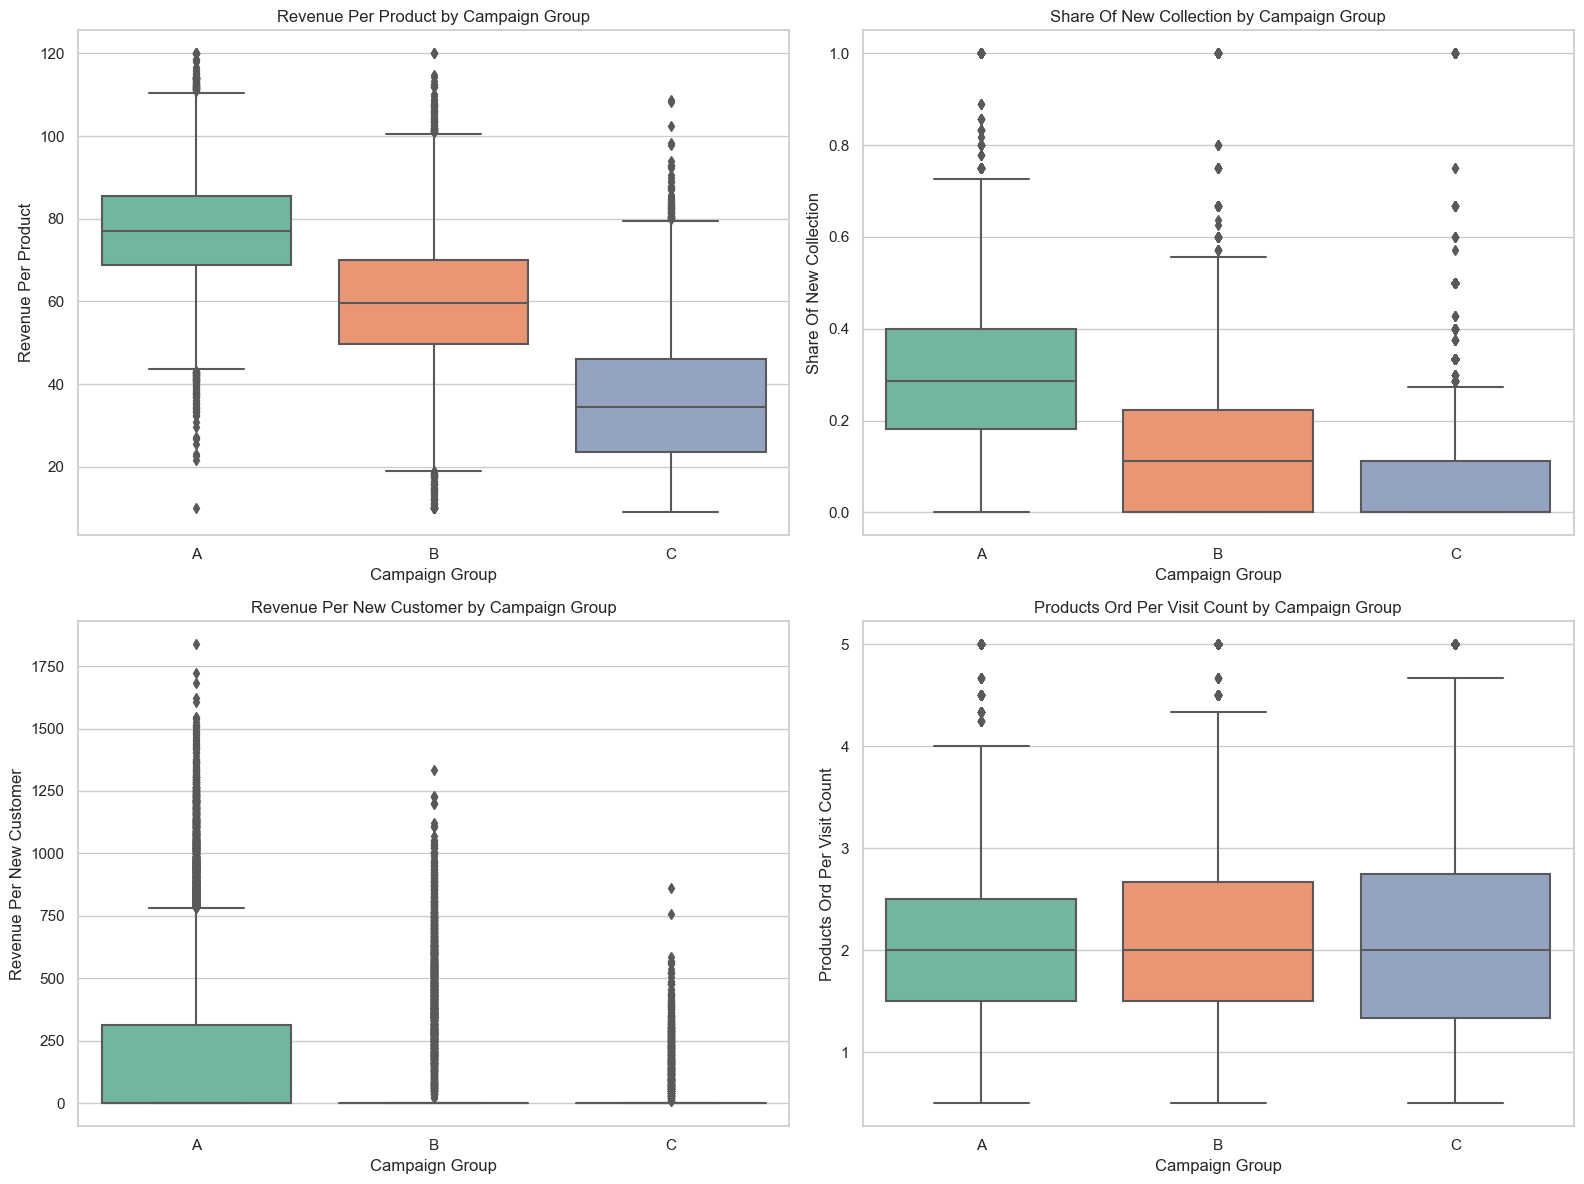

In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

important_kpis = [
    'revenue_per_product',
    'share_of_new_collection',
    'revenue_per_new_customer',
    'products_ord_per_visit_count'
]

plt.figure(figsize=(16, 12))

for idx, kpi in enumerate(important_kpis, 1):
    plt.subplot(2, 2, idx)
    sns.boxplot(data=df_stat, x='campaign_group', y=kpi, palette='Set2')
    plt.title(f"{kpi.replace('_', ' ').title()} by Campaign Group")
    plt.xlabel("Campaign Group")
    plt.ylabel(kpi.replace('_', ' ').title())

plt.tight_layout()
plt.show()


### Conclusions and Recommendations

| **Campaign**                                              | **Key Insights**                                                                                                     | **Recommendations**                                                                      |
| --------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **A** – 5% discount on full order with new collection     | Performed best across key KPIs: highest revenue per product, share of new collection, and revenue from new customers | Keep as the baseline. Consider testing a higher discount (7–10%) during peak seasons     |
| **B** – Free gift with new collection                     | Moderate performance. Gift may not be compelling enough to influence buying behavior                                 | Replace low-value random gifts with more tangible incentives (e.g., fixed-value voucher) |
| **C** – 50% chance for 10% loyalty discount via SMS/Email | Lowest performance across all KPIs. High uncertainty and weak communication channel                                  | Replace with guaranteed incentives; clarify benefits in SMS/Email; expand store coverage |

> #### ✅ Overall, Campaign A is the most effective, while Campaign C should be revised or removed. Further optimization can include testing different value propositions or communication formats.

## 7. Segmented Analysis

### Why segmented analysis?

- #### Better understand the effectiveness of each campaign on specific segments.

- #### Determine which segments respond best to each type of campaign.

- #### Optimize future campaign implementations by target group or store characteristics.

### Summary

| Segment          | KPIs (comparing by campaign)                                      |
| ---------------- | ------------------------------------------------------------------------ |
| Store Location   | Revenue/Visit, Share New Collection, Promo Utilized                      |
| Store Size       | Products/Customer, Revenue/Product, Promo Utilized                       |
| Gender           | Revenue/Customer, Promo Utilized, Share New Collection                   |
| Age Group        | Revenue/New Customer, Revenue/Product, Promo Utilized                    |
| Customer Segment | Revenue per New/Returning Customer, Promo Utilized, Share New Collection |


### 7.1. Store Location

> #### Because each customer_id is associated with only one store in the sample data, we will take advantage of the previously calculated df_stat table by merging the store_location information into df_stat

In [88]:
print(df_stat.columns.tolist())

['customer_id', 'campaign_group', 'visit_count', 'products_ord', 'new_collection_items', 'revenue', 'promo_utilized', 'is_new_customer', 'products_ord_per_visit_count', 'share_of_new_collection', 'new_collection_items_per_visit_count', 'revenue_per_visit_count', 'revenue_per_product', 'revenue_per_new_collection_item', 'revenue_per_new_customer', 'revenue_per_returning_customer', 'store_location_x', 'store_location_y', 'store_size_category_x', 'store_location', 'store_size_category_y']


In [92]:
# Collect unique store_location information for each customer_id
store_info = df[['customer_id', 'store_id', 'store_location', 'store_size_category']].drop_duplicates()

# Merge into df_stat
df_stat = df_stat.merge(store_info, on='customer_id', how='left')

# Check the merge
df_stat[['customer_id', 'campaign_group', 'store_location', 'store_size_category']].head()


,customer_id,campaign_group,store_location,store_size_category
0,2,A,Rural,Small
1,3,A,Urban,Medium
2,4,A,Urban,Small
3,5,B,Suburban,Medium
4,6,A,Rural,Small


In [79]:
# KPI by store_location và campaign_group
seg_location = df_stat.groupby(['store_location', 'campaign_group'], as_index=False).agg(
    total_visits=('visit_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    promo_utilized=('promo_utilized', 'sum'),
    total_customers=('customer_id', 'count')
)

# Calculate KPI
seg_location['revenue_per_visit'] = seg_location['total_revenue'] / seg_location['total_visits']
seg_location['share_new_collection'] = seg_location['total_new_collection'] / seg_location['total_products']
seg_location['promo_utilized_rate'] = seg_location['promo_utilized'] / seg_location['total_customers']


seg_location = seg_location[['store_location', 'campaign_group', 'revenue_per_visit', 'share_new_collection', 'promo_utilized_rate']]

seg_location.head()

,store_location,campaign_group,revenue_per_visit,share_new_collection,promo_utilized_rate
0,Rural,A,153.817632,0.301393,0.923529
1,Rural,B,120.246422,0.136094,0.562500
2,Rural,C,72.973892,0.069706,0.154396
3,Suburban,A,155.108690,0.302206,0.898000
4,Suburban,B,119.596662,0.136654,0.548570


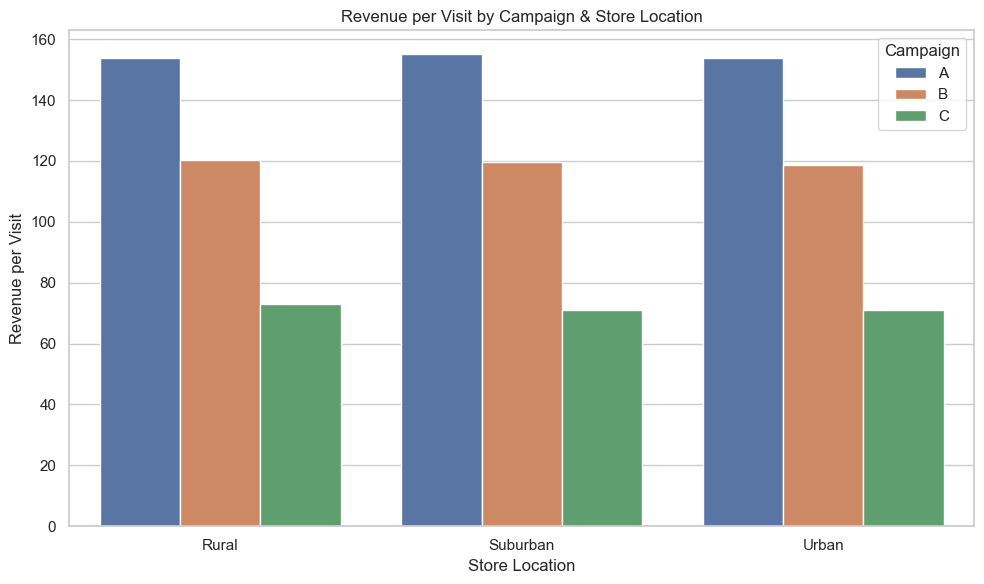

In [ ]:
# revenue_per_visit by store_location and campaign_group

plt.figure(figsize=(10, 6))
sns.barplot(data=seg_location, x='store_location', y='revenue_per_visit', hue='campaign_group')
plt.title('Revenue per Visit by Campaign & Store Location')
plt.ylabel('Revenue per Visit')
plt.xlabel('Store Location')
plt.legend(title='Campaign')
plt.tight_layout()
plt.show()

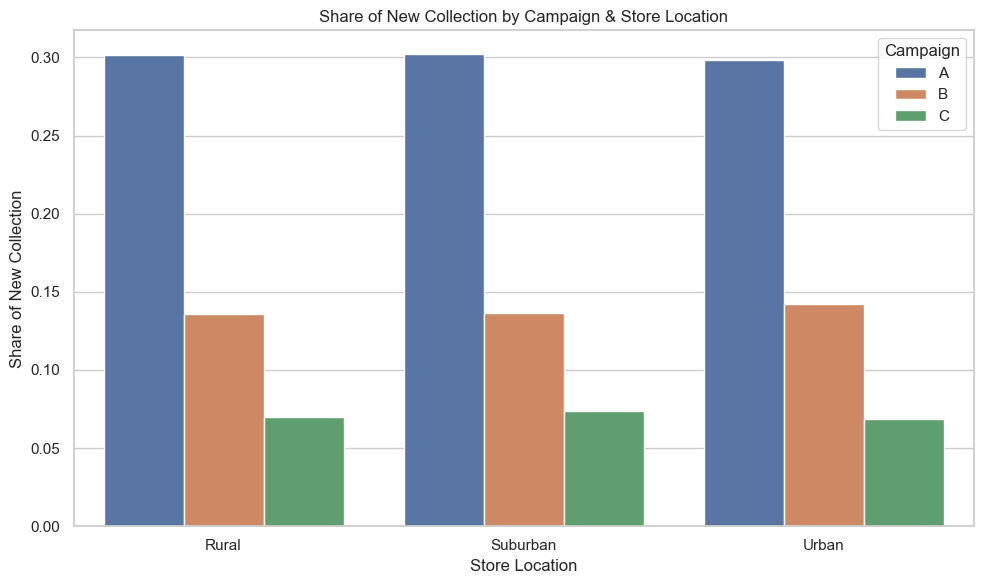

In [81]:
# Share of New Collection by store_location and campaign_group

plt.figure(figsize=(10, 6))
sns.barplot(data=seg_location, x='store_location', y='share_new_collection', hue='campaign_group')
plt.title('Share of New Collection by Campaign & Store Location')
plt.ylabel('Share of New Collection')
plt.xlabel('Store Location')
plt.legend(title='Campaign')
plt.tight_layout()
plt.show()


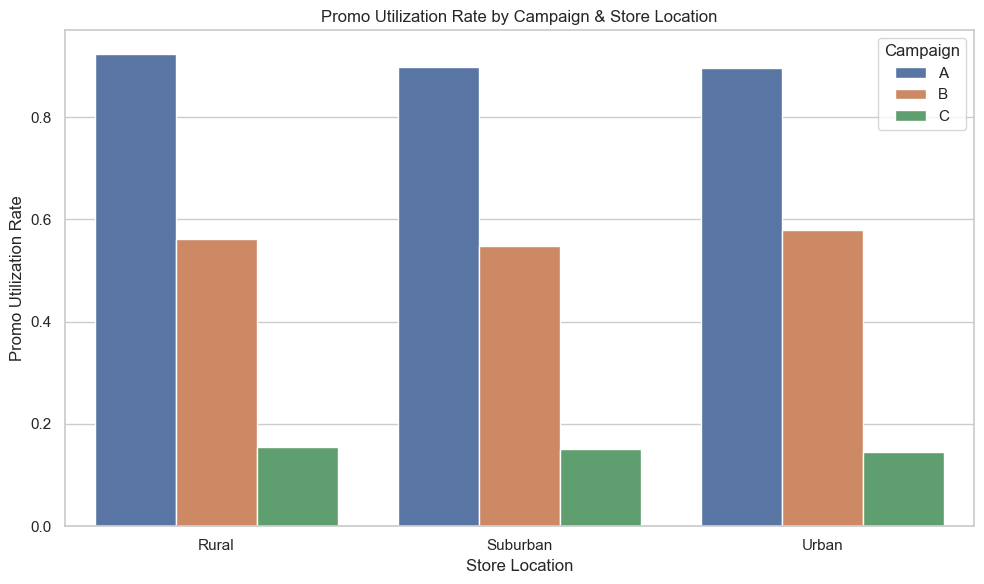

In [82]:
# Promo Utilization Rate by store_location and campaign_group

plt.figure(figsize=(10, 6))
sns.barplot(data=seg_location, x='store_location', y='promo_utilized_rate', hue='campaign_group')
plt.title('Promo Utilization Rate by Campaign & Store Location')
plt.ylabel('Promo Utilization Rate')
plt.xlabel('Store Location')
plt.legend(title='Campaign')
plt.tight_layout()
plt.show()

> #### Conclusion

- Campaign A is most effective in all store locations, but shows slightly better ROI in Suburban and Rural settings — possibly due to stronger price sensitivity.

- Campaign B is moderately effective and can be considered for Urban stores, where the appeal of free gifts may resonate more.

- Campaign C is ineffective across the board, particularly in Suburban and Urban areas — its uncertain mechanics likely reduce trust and clarity.

> #### Recommendation: Focus **Campaign A** in Suburban/Rural stores for maximum impact. Consider redesigning **Campaign C** into a more transparent and guaranteed incentive structure, especially if continuing in Urban environments.

### 7.2. Store Size Category

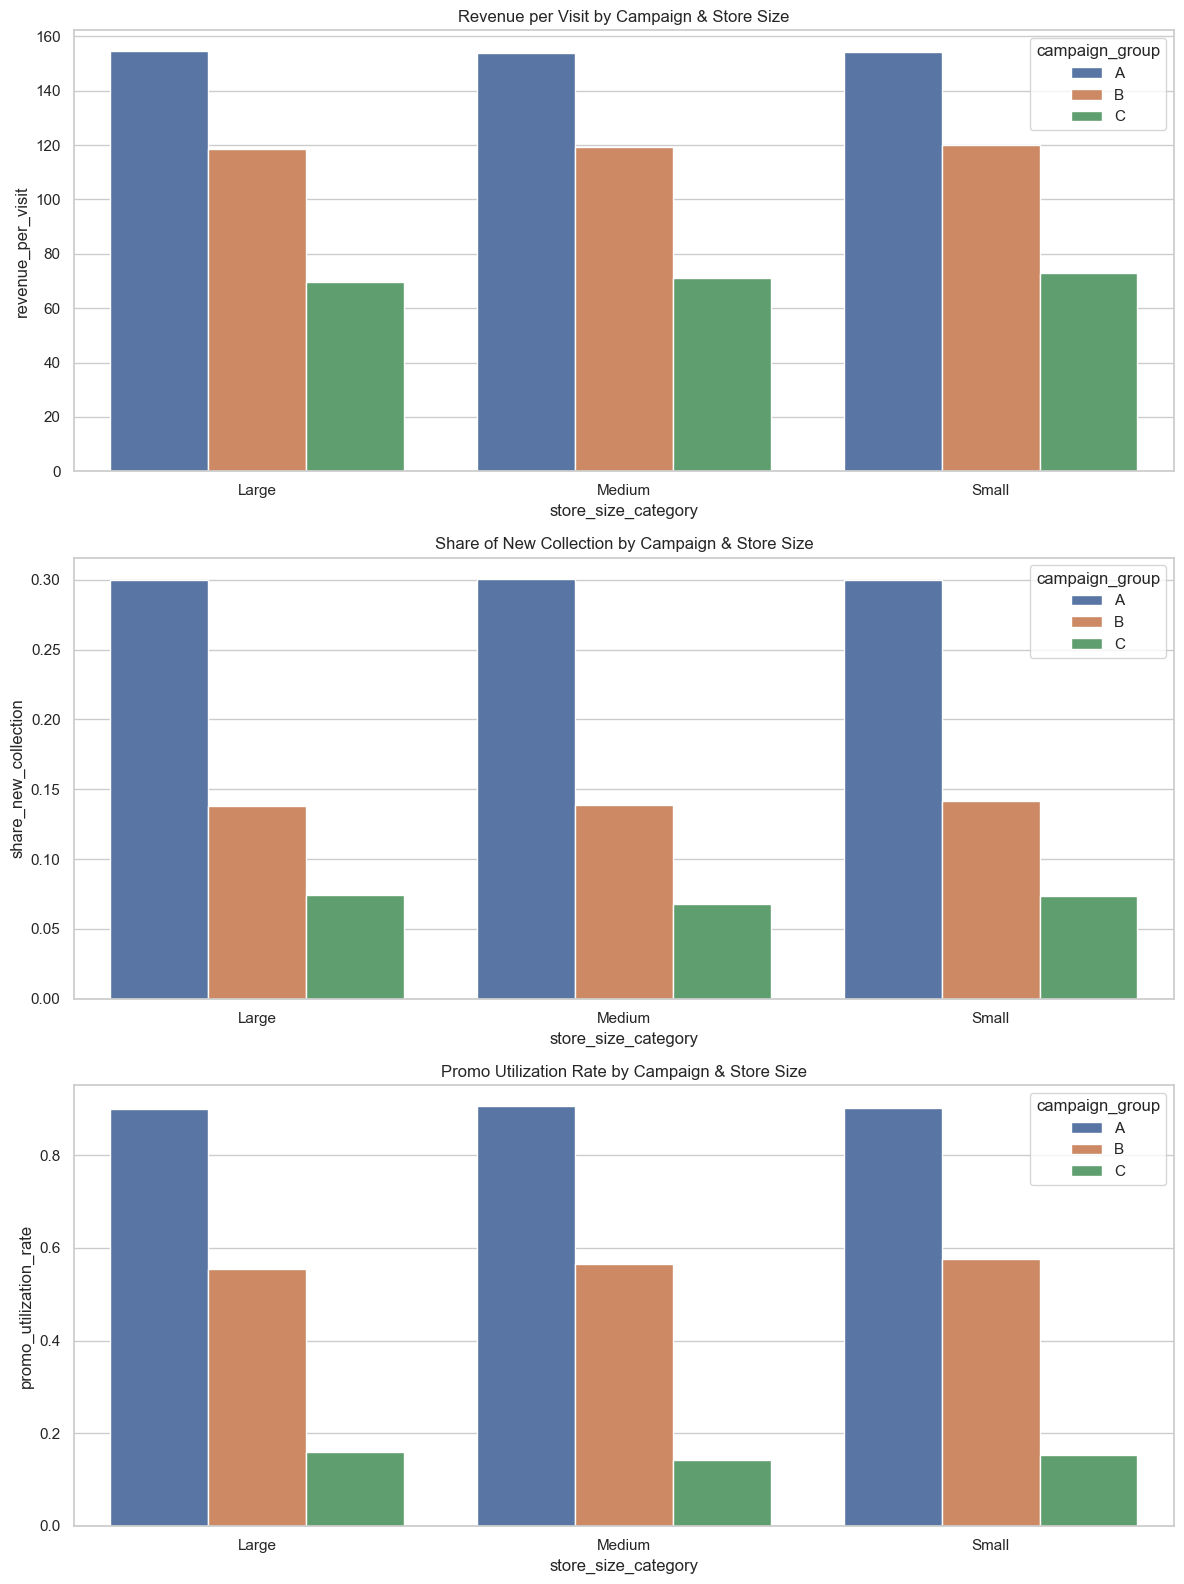

In [ ]:
# Calculate KPIs by store_size_category and campaign_group
seg_size = df_stat.groupby(['store_size_category', 'campaign_group'], as_index=False).agg(
    total_visits=('visit_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    promo_utilized=('promo_utilized', 'sum'),
    total_customers=('customer_id', 'count')
)

# Compute KPIs
seg_size['revenue_per_visit'] = seg_size['total_revenue'] / seg_size['total_visits']
seg_size['share_new_collection'] = seg_size['total_new_collection'] / seg_size['total_products']
seg_size['promo_utilization_rate'] = seg_size['promo_utilized'] / seg_size['total_customers']

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# Revenue per Visit
sns.barplot(data=seg_size, x='store_size_category', y='revenue_per_visit', hue='campaign_group', ax=axes[0])
axes[0].set_title('Revenue per Visit by Campaign & Store Size')

# Share of New Collection
sns.barplot(data=seg_size, x='store_size_category', y='share_new_collection', hue='campaign_group', ax=axes[1])
axes[1].set_title('Share of New Collection by Campaign & Store Size')

# Promo Utilization Rate
sns.barplot(data=seg_size, x='store_size_category', y='promo_utilization_rate', hue='campaign_group', ax=axes[2])
axes[2].set_title('Promo Utilization Rate by Campaign & Store Size')

plt.tight_layout()
plt.show()

> #### Summary:

- Campaign A is the most effective campaign across all store segments.

- Campaign B can be used as a secondary option for smaller stores or customers sensitive to non-monetary rewards.

- Campaign C is ineffective across all three segments and needs significant improvement if it is to continue to be used.

### 7.3. Gender & Age Group

In [96]:
df_stat.columns

Index(['customer_id', 'campaign_group', 'visit_count', 'products_ord',
       'new_collection_items', 'revenue', 'promo_utilized', 'is_new_customer',
       'products_ord_per_visit_count', 'share_of_new_collection',
       'new_collection_items_per_visit_count', 'revenue_per_visit_count',
       'revenue_per_product', 'revenue_per_new_collection_item',
       'revenue_per_new_customer', 'revenue_per_returning_customer',
       'store_id', 'store_location', 'store_size_category'],
      dtype='object')

In [98]:
# Collect unique customer information for each customer_id
customer_info = df[['customer_id', 'gender', 'age']].drop_duplicates()

# Merge into df_stat
df_stat = df_stat.merge(customer_info, on='customer_id', how='left')

# Create age_group column based on age
df_stat['age_group'] = pd.cut(
    df_stat['age'],
    bins=[0, 18, 25, 35, 45, 55, 100],
    labels=['<18', '18-25', '26-35', '36-45', '46-55', '55+'],
    right=False
)

# Check the merge
df_stat[['customer_id', 'gender', 'age_group']].head()


,customer_id,gender,age_group
0,2,Male,18-25
1,2,Male,46-55
2,3,Male,18-25
3,3,Male,46-55
4,3,Female,18-25


In [99]:
# Calculate KPI by gender and campaign_group
seg_gender = df_stat.groupby(['gender', 'campaign_group'], as_index=False).agg(
    total_visits=('visit_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    promo_utilized=('promo_utilized', 'sum'),
    total_customers=('customer_id', 'count')
)

# KPI calculations
seg_gender['revenue_per_visit'] = seg_gender['total_revenue'] / seg_gender['total_visits']
seg_gender['share_new_collection'] = seg_gender['total_new_collection'] / seg_gender['total_products']
seg_gender['promo_utilized_rate'] = seg_gender['promo_utilized'] / seg_gender['total_customers']


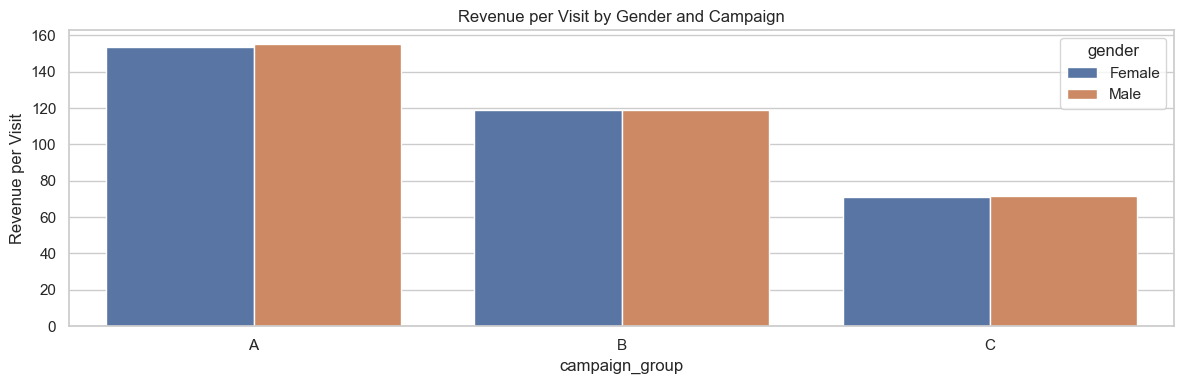

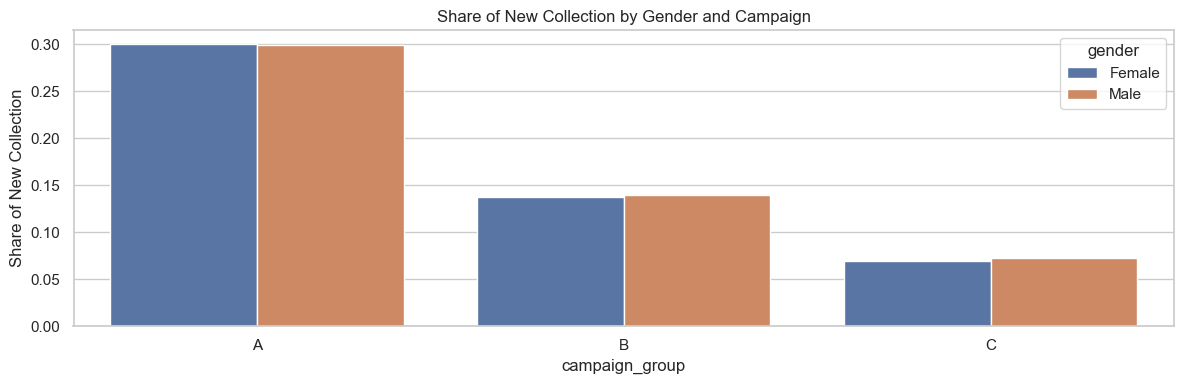

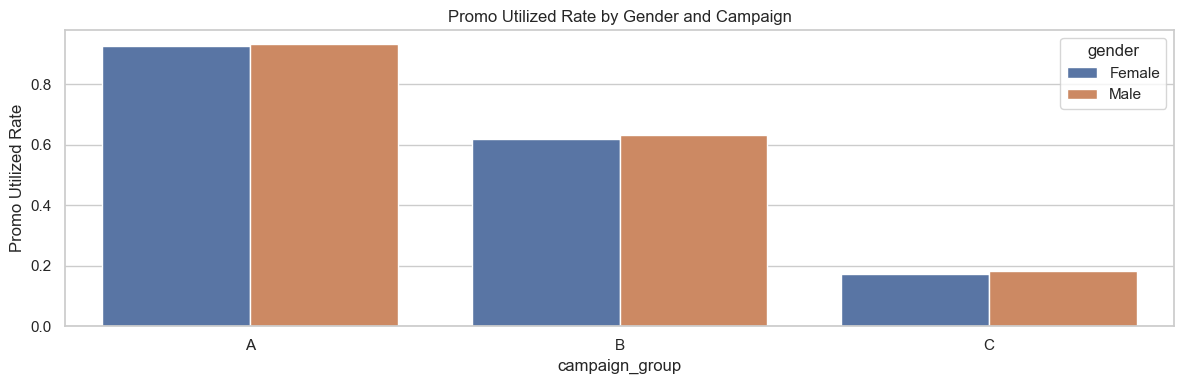

In [100]:
# Set style
sns.set(style='whitegrid')

# Plot Revenue per Visit
plt.figure(figsize=(12, 4))
sns.barplot(data=seg_gender, x='campaign_group', y='revenue_per_visit', hue='gender')
plt.title('Revenue per Visit by Gender and Campaign')
plt.ylabel('Revenue per Visit')
plt.tight_layout()
plt.show()

# Plot Share of New Collection
plt.figure(figsize=(12, 4))
sns.barplot(data=seg_gender, x='campaign_group', y='share_new_collection', hue='gender')
plt.title('Share of New Collection by Gender and Campaign')
plt.ylabel('Share of New Collection')
plt.tight_layout()
plt.show()

# Plot Promo Utilized Rate
plt.figure(figsize=(12, 4))
sns.barplot(data=seg_gender, x='campaign_group', y='promo_utilized_rate', hue='gender')
plt.title('Promo Utilized Rate by Gender and Campaign')
plt.ylabel('Promo Utilized Rate')
plt.tight_layout()
plt.show()


In [101]:
# KPI by age_group và campaign_group
seg_age = df_stat.groupby(['age_group', 'campaign_group'], observed=True, as_index=False).agg(
    total_visits=('visit_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    promo_utilized=('promo_utilized', 'sum'),
    total_customers=('customer_id', 'count')
)

# KPI calculations
seg_age['revenue_per_visit'] = seg_age['total_revenue'] / seg_age['total_visits']
seg_age['share_new_collection'] = seg_age['total_new_collection'] / seg_age['total_products']
seg_age['promo_utilization_rate'] = seg_age['promo_utilized'] / seg_age['total_customers']

# check the result
seg_age.head()

,age_group,campaign_group,total_visits,total_revenue,total_products,total_new_collection,promo_utilized,total_customers,revenue_per_visit,share_new_collection,promo_utilization_rate
0,18-25,A,39624,6151751.53,79811,23883,8005,8607,155.253168,0.299244,0.930057
1,18-25,B,21167,2535073.38,42217,5889,3554,5700,119.765360,0.139494,0.623509
2,18-25,C,9823,698374.58,19738,1367,589,3419,71.095855,0.069257,0.172273
3,26-35,A,35457,5470578.62,71098,21164,7029,7585,154.287690,0.297674,0.926697
4,26-35,B,18678,2207617.89,36869,5127,3122,4972,118.193484,0.139060,0.627916


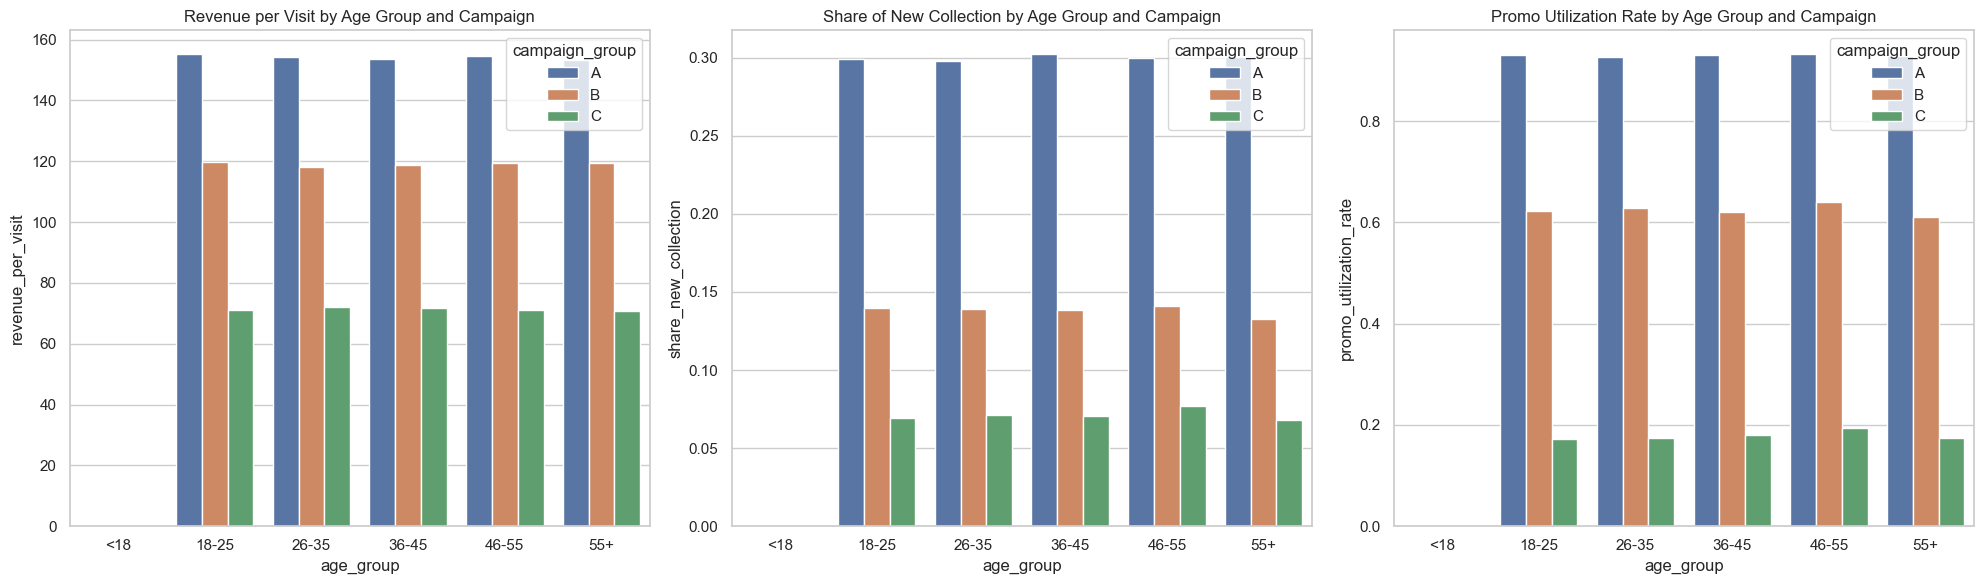

In [102]:
# Set style
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Revenue per Visit
sns.barplot(data=seg_age, x='age_group', y='revenue_per_visit', hue='campaign_group', ax=axs[0])
axs[0].set_title('Revenue per Visit by Age Group and Campaign')

# Share of New Collection
sns.barplot(data=seg_age, x='age_group', y='share_new_collection', hue='campaign_group', ax=axs[1])
axs[1].set_title('Share of New Collection by Age Group and Campaign')

# Promo Utilization Rate
sns.barplot(data=seg_age, x='age_group', y='promo_utilization_rate', hue='campaign_group', ax=axs[2])
axs[2].set_title('Promo Utilization Rate by Age Group and Campaign')

plt.tight_layout()
plt.show()


> #### Insights & Recommendations

- ##### Gender-Based Insights: No need to differentiate campaign strategy by gender — similar response across both groups.

- ##### Age-Based Insights:

- Campaign A should be the default campaign across all age groups due to consistent performance.

- Campaign B is moderately effective and may be suitable for back-up campaign.

- Campaign C underperforms across all metrics and requires redesign (promo usage below 20%).

### 7.4. Customer Segment

In [103]:
# KPI by customer_segment (is_new_customer) và campaign_group
seg_segment = df_stat.groupby(['is_new_customer', 'campaign_group'], observed=True, as_index=False).agg(
    total_visits=('visit_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    promo_utilized=('promo_utilized', 'sum'),
    total_customers=('customer_id', 'count')
)

# KPI calculations
seg_segment['revenue_per_visit'] = seg_segment['total_revenue'] / seg_segment['total_visits']
seg_segment['share_new_collection'] = seg_segment['total_new_collection'] / seg_segment['total_products']
seg_segment['promo_utilization_rate'] = seg_segment['promo_utilized'] / seg_segment['total_customers']

# Convert is_new_customer to categorical labels
seg_segment['customer_segment'] = seg_segment['is_new_customer'].map({True: 'New', False: 'Returning'})


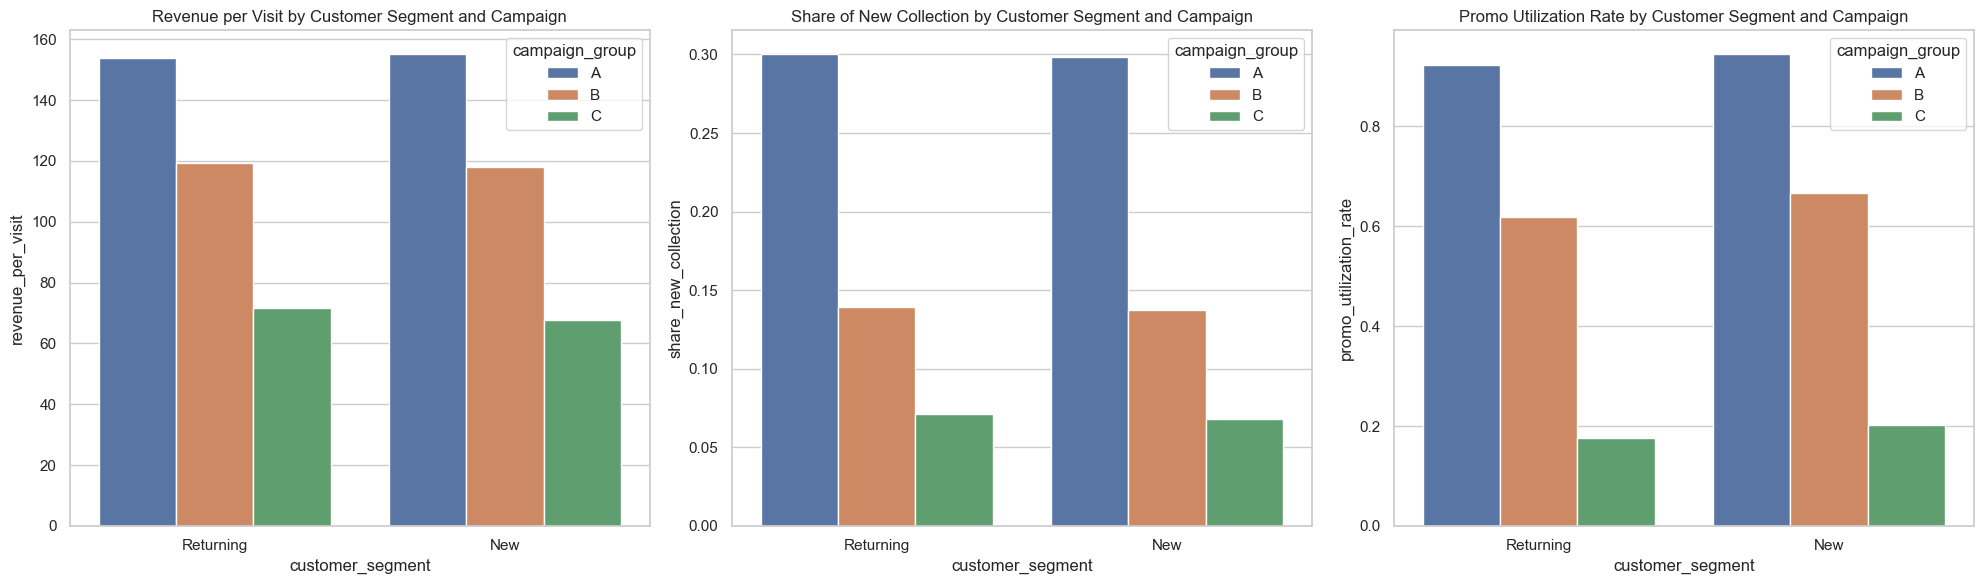

In [104]:
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Revenue per Visit
sns.barplot(data=seg_segment, x='customer_segment', y='revenue_per_visit', hue='campaign_group', ax=axs[0])
axs[0].set_title('Revenue per Visit by Customer Segment and Campaign')

# Share of New Collection
sns.barplot(data=seg_segment, x='customer_segment', y='share_new_collection', hue='campaign_group', ax=axs[1])
axs[1].set_title('Share of New Collection by Customer Segment and Campaign')

# Promo Utilization Rate
sns.barplot(data=seg_segment, x='customer_segment', y='promo_utilization_rate', hue='campaign_group', ax=axs[2])
axs[2].set_title('Promo Utilization Rate by Customer Segment and Campaign')

plt.tight_layout()
plt.show()

> #### Recommendations

- Campaign A is highly effective for both new and returning customers → should be scaled up as the core strategy.

- Campaign B can serve as a secondary campaign targeting new customers but is less impactful.

- Campaign C needs a complete redesign or limited use in test groups due to low engagement and ROI.

### 7.5. Customer Repeat Behavior

> #### Objective: Check whether customers, after purchasing in week T (with a specific campaign), will return to purchase in week T+1, T+2...?

In [107]:
# Create transaction table by customer_id and week

df_sorted = df.sort_values(['customer_id', 'week'])
df_sorted = df_sorted[['customer_id', 'week', 'campaign_group']]

In [108]:
# Create a checkbox column: whether the customer has a transaction next week or not
df_sorted['has_returned_next_week'] = df_sorted.groupby('customer_id')['week'].shift(-1) == df_sorted['week'] + 1

In [109]:
# Combine and calculate ratio by campaign_group
repeat_df = df_sorted[df_sorted['has_returned_next_week'].notnull()]

repeat_rate_by_campaign = repeat_df.groupby('campaign_group')['has_returned_next_week'].mean().reset_index()
repeat_rate_by_campaign.rename(columns={'has_returned_next_week': 'repeat_rate_next_week'}, inplace=True)

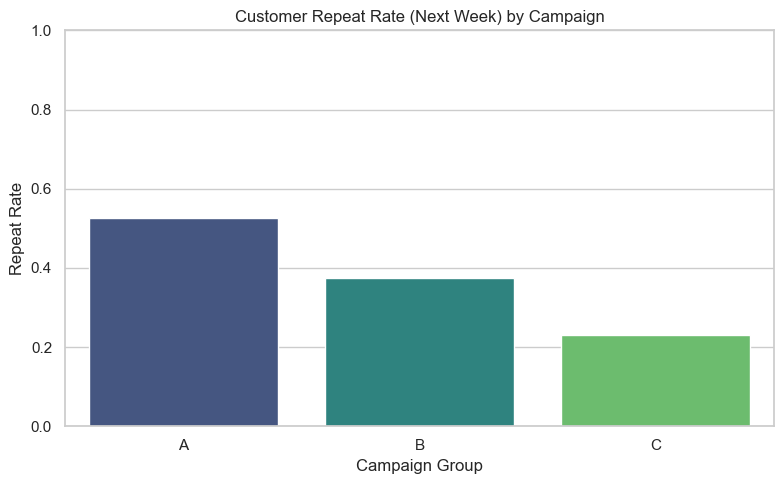

In [110]:
plt.figure(figsize=(8, 5))
sns.barplot(data=repeat_rate_by_campaign, x='campaign_group', y='repeat_rate_next_week', palette='viridis')
plt.title('Customer Repeat Rate (Next Week) by Campaign')
plt.ylabel('Repeat Rate')
plt.xlabel('Campaign Group')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


> #### Observations

- Campaign A has the highest repeat rate (~52%), indicating that the 5% discount is effective in encouraging repeat purchases.

- Campaign B shows a moderate repeat rate (~37%), suggesting that free gifts are appealing but may not be strong drivers of customer loyalty.

- Campaign C performs the worst with a repeat rate of ~23%, implying that a 50% chance of receiving a voucher is not persuasive enough to bring customers back.



> #### Conclusion

- Campaign A is the most effective in driving **short-term customer retention**.

- Campaign B (free gifts) may help with **initial attraction**, but lacks lasting engagement.

- Campaign C’s probabilistic offer is not reliable for retaining customers — especially in the week immediately after the purchase.

## 8. Final Summary – Marketing Analysis & A/B Testing of Campaigns A, B, and C


### 8.1. Objective
#### Evaluate the effectiveness of three promotional campaigns (A, B, C) in driving customer engagement, revenue, and retention — using comprehensive A/B testing, statistical validation, and segmented insights.

### 8.2. Key Findings


> #### 1. Data & Demographic Balance Checks
- No significant imbalance in store location, store size, gender, or age across campaign groups.

- Ensures that observed differences in performance are due to the campaigns themselves, not confounding variables.

---

> #### 2. Performance by Campaign (EDA & Statistical Testing)
- ANOVA and Tukey HSD confirm significant performance differences between all campaigns (p ≈ 0.0000).

| Metric                        | **Best**  | **Moderate** | **Weakest** |
| ----------------------------- | --------- | ------------ | ----------- |
| 🚀 New customer acquisition   | A         | B            | C           |
| 🧥 New collection engagement  | A         | B            | C           |
| 💰 Revenue per customer/visit | A         | B            | C           |
| 🎁 Promo usage & conversion   | A         | B            | C           |
| 🔁 Repeat purchase next week  | A (\~52%) | B (\~37%)    | C (\~23%)   |

---

> #### 3. Segmented Analysis
- Store Location: A performs well everywhere, especially Suburban & Rural. C underperforms across all.

- Store Size: A scales well in Medium & Large stores. C is ineffective regardless of store size.

- Gender: No meaningful difference in campaign response — no gender-based targeting needed.

- Age Group: A is consistent across all ages. B is secondary; C performs poorly across age groups.

- Customer Segment: A works best for both new and returning customers. C struggles to retain either.

---
> #### 4. Campaign-Specific Observations & Recommendations

| **Campaign** | **Mechanism**                           | **Summary**                                               | **Recommendations**                                                                 |
| ------------ | --------------------------------------- | --------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| **A**        | 5% discount with new collection item    | Most effective across all KPIs and segments               | ✅ Scale further. Consider testing higher discounts (e.g., 7–10%) during peak season |
| **B**        | Free gift with new collection item      | Moderately effective, especially in Urban/small stores    | 🔄 Test alternative incentives (e.g., fixed discount or higher-value gift)          |
| **C**        | 50% chance for 10% discount (SMS/email) | Weakest overall performance; low engagement and retention | ⚠️ Redesign with guaranteed rewards. Improve clarity in communication (SMS/email)   |


### 8.3. Final Conclusions

> #### Campaign A is the clear winner, driving both short-term and long-term success:

- Best at acquiring and retaining customers

- Highest revenue and promo efficiency

- Strong performance across all store and customer segments

> #### Campaign B is a viable secondary option, but needs optimization in incentives and targeting.

> #### Campaign C should be paused or redesigned, as it consistently underperforms in both impact and customer response.